# London - Analysis of Real Estate for Sale

In [126]:
# Get lxlm
!conda install -c anaconda lxml -y

# Install requests library
!conda install -c anaconda requests -y

# Install geopy library
!conda install -c conda-forge geopy --yes 

# Install folium library
!conda install -c conda-forge folium=0.5.0 --yes

# Install rightmove-webscraper (https://github.com/toby-p/rightmove_webscraper.py)
!pip install -U rightmove-webscraper

# Install opencage
!pip install opencage

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - lxml


The following packages will be UPDATED:

    certifi:         2020.4.5.1-py36h9f0ad1d_0 conda-forge --> 2020.4.5.1-py36_0 anaconda
    openssl:         1.1.1g-h516909a_0         conda-forge --> 1.1.1g-h7b6447c_0 anaconda

The following packages will be DOWNGRADED:

    ca-certificates: 2020.4.5.1-hecc5488_0     conda-forge --> 2020.1.1-0        anaconda

Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be UPDATED:

    ca-certificates: 2020.1.1-0        anaconda --> 2020.4.5.1-hecc5488_0     conda-forge
    certifi:         2020.4.5.1-py36_0 anaconda --> 2020.4.5.1-py36h9f0ad1d_0 conda

In [4]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests
import lxml
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import folium # plotting library
from sklearn.cluster import KMeans

from opencage.geocoder import OpenCageGeocode
from pprint import pprint

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

ModuleNotFoundError: No module named 'folium'

# ----------------------------------------------------------------------------------------
## 1. Import the datasets to be used and clean the data for further analysis. 


## First, I'll use the rightmove_webscraper package to scrape the data from RightMove.co.uk to analyze properties for sale in London. 

In [128]:
from rightmove_webscraper import RightmoveData

#url = "https://www.rightmove.co.uk/property-for-sale/find.html?searchType=SALE&locationIdentifier=REGION%5E87490&insId=1&radius=0.0&minPrice=&maxPrice=&minBedrooms=&maxBedrooms=&displayPropertyType=&maxDaysSinceAdded=&_includeSSTC=on&sortByPriceDescending=&primaryDisplayPropertyType=&secondaryDisplayPropertyType=&oldDisplayPropertyType=&oldPrimaryDisplayPropertyType=&newHome=&auction=false"
url="https://www.rightmove.co.uk/property-for-sale/find.html?searchType=SALE&locationIdentifier=REGION%5E87490&insId=1&radius=0.0&minPrice=&maxPrice=2000000&minBedrooms=&maxBedrooms=&displayPropertyType=&maxDaysSinceAdded=14&_includeSSTC=on&sortByPriceDescending=&primaryDisplayPropertyType=&secondaryDisplayPropertyType=&oldDisplayPropertyType=&oldPrimaryDisplayPropertyType=&newHome=&auction=false"
rm = RightmoveData(url)

### listing_data defined below is the property listing data scraped from RightMove.co.uk

In [129]:
listing_data=rm.get_results

In [130]:
print(listing_data.shape)
listing_data.head(10)

(1050, 8)


,price,type,address,url,agent_url,postcode,number_bedrooms,search_date
0,510000.0,1 bedroom apartment for sale,"Osiers Square, Wandsworth, SW18",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW18,1.0,2020-05-03 14:46:50.675486
1,2000000.0,4 bedroom end of terrace house for sale,"Malvern Terrace, Islington, London, N1",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N1,4.0,2020-05-03 14:46:50.675486
2,2000000.0,3 bedroom duplex for sale,"The Avenue,\r\nLondon,\r\nNW6",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/developer/branch/Re...,NW6,3.0,2020-05-03 14:46:50.675486
3,2000000.0,3 bedroom duplex for sale,"The Avenue,\r\nLondon,\r\nNW6",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/developer/branch/Re...,NW6,3.0,2020-05-03 14:46:50.675486
4,2000000.0,3 bedroom flat for sale,"Milliner House, Hortensia Road, London, SW10",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW10,3.0,2020-05-03 14:46:50.675486
5,2000000.0,4 bedroom terraced house for sale,"Aubert Park, London, N5",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N5,4.0,2020-05-03 14:46:50.675486
6,1999999.0,2 bedroom detached house for sale,"St Edmunds Terrace, St Johns Wood",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,NaN,2.0,2020-05-03 14:46:50.675486
7,1999950.0,3 bedroom flat for sale,"Cleveland Square, Lancaster Gate, London, W2",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,W2,3.0,2020-05-03 14:46:50.675486
8,1999950.0,4 bedroom mews house for sale,"Russell Gardens Mews, Kensington & Chelsea",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,NaN,4.0,2020-05-03 14:46:50.675486
9,1975000.0,4 bedroom terraced house for sale,"Highlever Road, London, W10",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,W10,4.0,2020-05-03 14:46:50.675486


### Next, clean the data for further analysis. Several steps here: 
### 1. Exclude the listings where postcode is NA (since we'll use the location data later on to explore the venues nearby). 
### 2. Exclude the listings without price data. Also, exclude the listings with price less than 100K to make sure this is a genuine listing. 
### 3. Only use the data that is unique based on the type, address and number of bedrooms columns as the same property can be listed multiple times over time. 

In [131]:
listing_data=listing_data[listing_data.postcode.notna()]
listing_data=listing_data[listing_data.price.notna()]
listing_data=listing_data[listing_data.price>100000]
listing_data=listing_data.drop_duplicates(subset=["type","address","number_bedrooms"], keep='first').reset_index()

In [132]:
listing_data.shape

(693, 9)

## Next, I import the csv file that matches the postcode and district name. This is scraped form Wikipedia and saved as a csv file for convenience. 

In [3]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_5239427317144ef8bd795771516ac806 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='TAs5eoL1HHyKPfRKQMot2S-2SasdR47f-KEChHKGlGJ8',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_5239427317144ef8bd795771516ac806.get_object(Bucket='londonrealestateanalysis-donotdelete-pr-8aygv8ezvfq4zk',Key='London_districts.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
district_data = pd.read_csv(body)
district_data.head()


,PostCode,District Name
0,E1,Eastern Head district
1,E2,Bethnal Green
2,E3,Bow
3,E4,Chingford
4,E5,Clapton


## Now we can merge the listing_data with district_data to include the district of each property. This will help us later on when exploring data and creating visuals. 

In [134]:
listing_data=pd.merge(left=listing_data, right=district_data, left_on="postcode", right_on="PostCode", how = 'left')
listing_data.drop("PostCode", axis=1, inplace=True)

In [135]:
listing_data.shape
listing_data.head(10)

,index,price,type,address,url,agent_url,postcode,number_bedrooms,search_date,District Name
0,0,510000.0,1 bedroom apartment for sale,"Osiers Square, Wandsworth, SW18",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW18,1.0,2020-05-03 14:46:50.675486,Wandsworth
1,1,2000000.0,4 bedroom end of terrace house for sale,"Malvern Terrace, Islington, London, N1",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N1,4.0,2020-05-03 14:46:50.675486,Head district
2,2,2000000.0,3 bedroom duplex for sale,"The Avenue,\r\nLondon,\r\nNW6",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/developer/branch/Re...,NW6,3.0,2020-05-03 14:46:50.675486,Kilburn
3,4,2000000.0,3 bedroom flat for sale,"Milliner House, Hortensia Road, London, SW10",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW10,3.0,2020-05-03 14:46:50.675486,West Brompton
4,5,2000000.0,4 bedroom terraced house for sale,"Aubert Park, London, N5",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N5,4.0,2020-05-03 14:46:50.675486,Highbury
5,7,1999950.0,3 bedroom flat for sale,"Cleveland Square, Lancaster Gate, London, W2",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,W2,3.0,2020-05-03 14:46:50.675486,Head district
6,9,1975000.0,4 bedroom terraced house for sale,"Highlever Road, London, W10",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,W10,4.0,2020-05-03 14:46:50.675486,North Kensington
7,10,1950000.0,2 bedroom apartment for sale,"Montagu Square, London, W1H",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,W1H,2.0,2020-05-03 14:46:50.675486,NaN
8,11,1850000.0,2 bedroom apartment for sale,"1 Kings Gate Walk, Westminster, SW1E",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW1E,2.0,2020-05-03 14:46:50.675486,NaN
9,12,1850000.0,3 bedroom penthouse for sale,"Sales Gallery,\r\nOrchard Place,\r\nLondon,\r\...",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/developer/branch/Ba...,E14,3.0,2020-05-03 14:46:50.675486,Poplar


# ------------------------------------------------------------------------------------------------------------------
## 2.  Use the address of each listing to obtain the coordinates using OpenCage API. Coordinates obtained here will be an input for Foursquare API later on to explore the venues nearby. 

In [69]:
listing_data.head()

,index,price,type,address,url,agent_url,postcode,number_bedrooms,search_date,District Name
0,0,140000.0,3 bedroom apartment for sale,Hancock Road\r\nLondon\r\nE3 3DA,http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/developer/branch/Si...,E3,3.0,2020-05-03 12:15:48.095597,Bow
1,1,2000000.0,4 bedroom end of terrace house for sale,"Malvern Terrace, Islington, London, N1",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N1,4.0,2020-05-03 12:15:48.095597,Head district
2,2,2000000.0,4 bedroom terraced house for sale,"Aubert Park, London, N5",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N5,4.0,2020-05-03 12:15:48.095597,Highbury
3,3,2000000.0,3 bedroom flat for sale,"Milliner House, Hortensia Road, London, SW10",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW10,3.0,2020-05-03 12:15:48.095597,West Brompton
4,4,2000000.0,3 bedroom duplex for sale,"The Avenue,\r\nLondon,\r\nNW6",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/developer/branch/Re...,NW6,3.0,2020-05-03 12:15:48.095597,Kilburn


In [136]:
addresses =listing_data["address"]

import json

latitudes = [] # Initializing the latitude array
longitudes = [] # Initializing the longitude array
address_col=[] 

for address in addresses : 
    place_name = address 
    #+ " London" # Formats the place name
    url = 'https://api.opencagedata.com/geocode/v1/json?q={}&countrycode=uk&key={}'.format(place_name, "87024f3e2258436f980c9b1d2f9f40d2") # Gets the proper url to make the API call
    obj = json.loads(requests.get(url).text) # Loads the JSON file in the form of a python dictionary
    
    results = obj['results'] # Extracts the results information out of the JSON file
    if len(results)>0:
        lat = results[0]['geometry']['lat'] # Extracts the latitude value
        lng = results[0]['geometry']['lng'] # Extracts the longitude value
    else:
        lat=np.nan
        lng=np.nan
         
    
    address_col.append(address)
    latitudes.append(lat) # Appending to the list of latitudes
    longitudes.append(lng) # Appending to the list of longitudes

### I check below whether coordinates of some properties are unidentifies through their address. I exlude the properties with NA coordinates from the dataset. 

In [137]:
coordinates=pd.DataFrame()
coordinates["address"]=address_col
coordinates["Latitude"]=latitudes
coordinates["Longitude"]=longitudes
coordinates.head()

,address,Latitude,Longitude
0,"Osiers Square, Wandsworth, SW18",51.460807,-0.196209
1,"Malvern Terrace, Islington, London, N1",51.539122,-0.109804
2,"The Avenue,\r\nLondon,\r\nNW6",51.541552,-0.210559
3,"Milliner House, Hortensia Road, London, SW10",51.482351,-0.186241
4,"Aubert Park, London, N5",51.555531,-0.101769


In [138]:
coordinates.shape
coordinates.drop_duplicates(subset=["address"], keep='first', inplace=True)

In [142]:
coordinates.shape

(639, 3)

In [140]:
listing_data=pd.merge(left=listing_data, right=coordinates, left_on="address", right_on="address", how="left")
listing_data.shape
#listing_data.drop(["PostalCode","index"], axis=1, inplace=True)

(693, 12)

In [143]:
listing_data.head(10)

,index,price,type,address,url,agent_url,postcode,number_bedrooms,search_date,District Name,Latitude,Longitude
0,0,510000.0,1 bedroom apartment for sale,"Osiers Square, Wandsworth, SW18",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW18,1.0,2020-05-03 14:46:50.675486,Wandsworth,51.460807,-0.196209
1,1,2000000.0,4 bedroom end of terrace house for sale,"Malvern Terrace, Islington, London, N1",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N1,4.0,2020-05-03 14:46:50.675486,Head district,51.539122,-0.109804
2,2,2000000.0,3 bedroom duplex for sale,"The Avenue,\r\nLondon,\r\nNW6",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/developer/branch/Re...,NW6,3.0,2020-05-03 14:46:50.675486,Kilburn,51.541552,-0.210559
3,4,2000000.0,3 bedroom flat for sale,"Milliner House, Hortensia Road, London, SW10",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW10,3.0,2020-05-03 14:46:50.675486,West Brompton,51.482351,-0.186241
4,5,2000000.0,4 bedroom terraced house for sale,"Aubert Park, London, N5",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N5,4.0,2020-05-03 14:46:50.675486,Highbury,51.555531,-0.101769
5,7,1999950.0,3 bedroom flat for sale,"Cleveland Square, Lancaster Gate, London, W2",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,W2,3.0,2020-05-03 14:46:50.675486,Head district,51.514300,-0.190500
6,9,1975000.0,4 bedroom terraced house for sale,"Highlever Road, London, W10",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,W10,4.0,2020-05-03 14:46:50.675486,North Kensington,51.520512,-0.224509
7,10,1950000.0,2 bedroom apartment for sale,"Montagu Square, London, W1H",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,W1H,2.0,2020-05-03 14:46:50.675486,NaN,51.517600,-0.161200
8,11,1850000.0,2 bedroom apartment for sale,"1 Kings Gate Walk, Westminster, SW1E",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW1E,2.0,2020-05-03 14:46:50.675486,NaN,51.508500,-0.125700
9,12,1850000.0,3 bedroom penthouse for sale,"Sales Gallery,\r\nOrchard Place,\r\nLondon,\r\...",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/developer/branch/Ba...,E14,3.0,2020-05-03 14:46:50.675486,Poplar,51.508043,0.007271


### Remove the properties whose coordinates couldn't be obtained. 

In [144]:
listing_data.dropna(subset=["Latitude","Longitude" ],inplace=True)
listing_data.shape

(664, 12)

In [155]:
listing_data.head()

,index,price,type,address,url,agent_url,postcode,number_bedrooms,search_date,District Name,Latitude,Longitude
0,0,510000.0,1 bedroom apartment for sale,"Osiers Square, Wandsworth, SW18",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW18,1.0,2020-05-03 14:46:50.675486,Wandsworth,51.460807,-0.196209
1,1,2000000.0,4 bedroom end of terrace house for sale,"Malvern Terrace, Islington, London, N1",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N1,4.0,2020-05-03 14:46:50.675486,Head district,51.539122,-0.109804
2,2,2000000.0,3 bedroom duplex for sale,"The Avenue,\r\nLondon,\r\nNW6",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/developer/branch/Re...,NW6,3.0,2020-05-03 14:46:50.675486,Kilburn,51.541552,-0.210559
3,4,2000000.0,3 bedroom flat for sale,"Milliner House, Hortensia Road, London, SW10",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW10,3.0,2020-05-03 14:46:50.675486,West Brompton,51.482351,-0.186241
4,5,2000000.0,4 bedroom terraced house for sale,"Aubert Park, London, N5",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N5,4.0,2020-05-03 14:46:50.675486,Highbury,51.555531,-0.101769


In [5]:
from project_lib import Project
project = Project(None, '6f939d73-f013-40c5-b895-e522890696a9', 'p-1908827532e2a2408b24bd415f250b57c60f7716')
pc = project.project_context

In [159]:
project.save_data(data=listing_data.to_csv(index=False),file_name='listing_data.csv',overwrite=True)

{'file_name': 'listing_data.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'londonrealestateanalysis-donotdelete-pr-8aygv8ezvfq4zk',
 'asset_id': 'f90f28a4-2557-4dbb-8d8d-29938bf5b7f0'}

In [7]:
client_5239427317144ef8bd795771516ac806 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='TAs5eoL1HHyKPfRKQMot2S-2SasdR47f-KEChHKGlGJ8',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_5239427317144ef8bd795771516ac806.get_object(Bucket='londonrealestateanalysis-donotdelete-pr-8aygv8ezvfq4zk',Key='listing_data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

listing_data = pd.read_csv(body)
listing_data.head()


NameError: name 'ibm_boto3' is not defined

# --------------------------------------------------------------------------------------------
## 3. Explore the venues in 500m. vicinity of each listing using Foursquare API. As I explain later on, because there are too many categories, I'll focus my analysis on the top 20 most common venue types in the listing data. 




### First, I'll use Foursquare API to add top 10 venues in each zipcode to district_data. 

In [160]:
CLIENT_ID = 'B5KWWDFHTON23TDXFR2TXATYBJQMYXICEEJWOSTX2YIAUZIC' # your Foursquare ID
CLIENT_SECRET = 'FVZXWADC3JUKZKIMRC40LFNTRSHC51MDTVKWHF4IJMGXTDC5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: B5KWWDFHTON23TDXFR2TXATYBJQMYXICEEJWOSTX2YIAUZIC
CLIENT_SECRET:FVZXWADC3JUKZKIMRC40LFNTRSHC51MDTVKWHF4IJMGXTDC5


### I'll create a function to analyze the nearby venues. 

In [161]:
LIMIT = 100
def getNearbyVenues(addresses, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for address, lat, lng in zip(addresses, latitudes, longitudes):
        print(address)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
           CLIENT_ID, CLIENT_SECRET,  
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        response_res=requests.get(url).json()
       # print(response_res)
       # print(lat)
       # print(lng)
        results = response_res["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            address, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Address', 
                  'Address Latitude', 
                  'Address Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [162]:
london_venues = getNearbyVenues(addresses=listing_data['address'],
                                   latitudes=listing_data['Latitude'],
                                   longitudes=listing_data['Longitude']
                                  )

Osiers Square, Wandsworth, SW18
Malvern Terrace, Islington, London, N1
The Avenue,
London,
NW6
Milliner House, Hortensia Road, London, SW10
Aubert Park, London, N5
Cleveland Square, Lancaster Gate, London, W2
Highlever Road, London, W10
Montagu Square, London, W1H
1 Kings Gate Walk, Westminster, SW1E
Sales Gallery,
Orchard Place,
London,
E14 0JZ
Principal Tower, 2 Principal Place, Worship Street, London, EC2A
Clifton Road, Wimbledon Village, London, SW19
Clifton Road, Wimbledon, London, SW19
Clifton Road, London, SW19
Northolme Road, London, N5
St Petersburgh Place, Bayswater, W2
Egerton Gardens, Chelsea, London, SW3
Tetcott Road, Chelsea, London, SW10
Crescent Lane, SW4
Elnathan Mews, London, W9
Helena Square, London, SE16
Warwick Avenue, Little Venice W9, London, W9
Lincoln Square, Covent Garden, WC2
Hurlingham Square, Peterborough Road, London, SW6
Bolton Studios, 17B Gilston Road, London, SW10
The Water Gardens, Burwood Place, Hyde Park, London, W2
Dunstan Road, Golders Green, Lond

In [163]:
print(london_venues.shape)
london_venues.head(10)

(23128, 7)


,Address,Address Latitude,Address Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Osiers Square, Wandsworth, SW18",51.460807,-0.196209,Queen Adelaide,51.459973,-0.199380,Pub
1,"Osiers Square, Wandsworth, SW18",51.460807,-0.196209,Putt In The Park,51.461758,-0.201163,Mini Golf
2,"Osiers Square, Wandsworth, SW18",51.460807,-0.196209,King's Arms,51.457344,-0.194708,Pub
3,"Osiers Square, Wandsworth, SW18",51.460807,-0.196209,The Grapes,51.458719,-0.190589,Pub
4,"Osiers Square, Wandsworth, SW18",51.460807,-0.196209,The Black Chapel,51.456831,-0.194796,Coffee Shop
5,"Osiers Square, Wandsworth, SW18",51.460807,-0.196209,The Cat's Back,51.461906,-0.199423,Pub
6,"Osiers Square, Wandsworth, SW18",51.460807,-0.196209,Virgin Active,51.462377,-0.189963,Gym / Fitness Center
7,"Osiers Square, Wandsworth, SW18",51.460807,-0.196209,The Thai,51.459859,-0.189345,Thai Restaurant
8,"Osiers Square, Wandsworth, SW18",51.460807,-0.196209,Marco Polo,51.462535,-0.199214,Italian Restaurant
9,"Osiers Square, Wandsworth, SW18",51.460807,-0.196209,Hop Pole,51.459303,-0.198337,Pub


In [165]:
london_address_venues=london_venues.groupby(["Address", "Venue Category"], as_index=False).count()

In [166]:
london_address_venues.drop(columns=["Address Latitude", "Address Longitude","Venue Latitude", "Venue Longitude"], inplace=True)

In [169]:
project.save_data(data=london_address_venues.to_csv(index=False),file_name='london_address_venues.csv',overwrite=True)

{'file_name': 'london_address_venues.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'londonrealestateanalysis-donotdelete-pr-8aygv8ezvfq4zk',
 'asset_id': 'afd057fc-c600-4949-8cdc-0e0bffefea04'}

In [9]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

client_5239427317144ef8bd795771516ac806 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='TAs5eoL1HHyKPfRKQMot2S-2SasdR47f-KEChHKGlGJ8',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_5239427317144ef8bd795771516ac806.get_object(Bucket='londonrealestateanalysis-donotdelete-pr-8aygv8ezvfq4zk',Key='london_address_venues.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

london_address_venues = pd.read_csv(body)
london_address_venues.head()


,Address,Venue Category,Venue
0,"Ashby Apartments, Plumstead High Street, Lond...",African Restaurant,1
1,"Ashby Apartments, Plumstead High Street, Lond...",Asian Restaurant,1
2,"Ashby Apartments, Plumstead High Street, Lond...",Bakery,2
3,"Ashby Apartments, Plumstead High Street, Lond...",Bookstore,1
4,"Ashby Apartments, Plumstead High Street, Lond...",Breakfast Spot,1


In [10]:
london_pivot=london_address_venues.pivot(index="Address", columns="Venue Category", values="Venue")

In [8]:
london_pivot.fillna(0, inplace=True)

In [9]:
london_pivot.head()

Venue Category,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
Address,,,,,,,,,,,,,,,,,,,,,
"Ashby Apartments, Plumstead High Street, London, SE18",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Giffin Street, London, SE8",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"St. Georges Square, Pimlico, SW1V",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tooley Street SE1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"""River Views "" Westferry Road, London E14",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
venue_totals=london_pivot.sum(axis=0).to_frame()

In [35]:
venue_totals.reset_index(inplace=True)

In [43]:
venue_totals.shape
venue_totals.columns

Index(['Venue Category', 'Totals'], dtype='object')

In [42]:
venue_totals.rename(columns={"Venue Category":"Venue Category", 0:"Totals"}, inplace=True)

In [46]:
venue_totals.sort_values(by="Totals",na_position='first', ascending=False, inplace=True)

### Because there are too many categories to analyze, I will focus my analysis for clusterin on the top 20 most common venue categories.I will define the top 20 category types as a string and later on cluster based on the number of top 20 venue types in the 500m. vicinity of each property. 

In [64]:
category_subset=venue_totals.iloc[0:20,0].tolist()

### Next, I'll get the london_pivot one hot encoded data that is within the top 20 category. Then, I'll merge this count data for top 20 venue types with listing_data, which will be the final dataset to be analyzed. 

In [77]:
london_pivot_subset=london_pivot[category_subset]

In [78]:
listing_data_venues=pd.merge(left=listing_data, right=london_pivot_subset, left_on="address", right_on="Address", how="left")
listing_data_venues.shape

(664, 32)

### listing_data_venues is the final dataset we will use for both exploratory analysis and clustering. 

In [79]:
listing_data_venues.head()

,index,price,type,address,url,agent_url,postcode,number_bedrooms,search_date,District Name,...,Bakery,Bar,Indian Restaurant,Restaurant,Burger Joint,Supermarket,Bus Stop,Cocktail Bar,Plaza,Theater
0,0,510000.0,1 bedroom apartment for sale,"Osiers Square, Wandsworth, SW18",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW18,1.0,2020-05-03 14:46:50.675486,Wandsworth,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2000000.0,4 bedroom end of terrace house for sale,"Malvern Terrace, Islington, London, N1",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N1,4.0,2020-05-03 14:46:50.675486,Head district,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,2,2000000.0,3 bedroom duplex for sale,"The Avenue,\r\nLondon,\r\nNW6",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/developer/branch/Re...,NW6,3.0,2020-05-03 14:46:50.675486,Kilburn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2000000.0,3 bedroom flat for sale,"Milliner House, Hortensia Road, London, SW10",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW10,3.0,2020-05-03 14:46:50.675486,West Brompton,...,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
4,5,2000000.0,4 bedroom terraced house for sale,"Aubert Park, London, N5",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N5,4.0,2020-05-03 14:46:50.675486,Highbury,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [11]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_5239427317144ef8bd795771516ac806 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='TAs5eoL1HHyKPfRKQMot2S-2SasdR47f-KEChHKGlGJ8',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')
body = client_5239427317144ef8bd795771516ac806.get_object(Bucket='londonrealestateanalysis-donotdelete-pr-8aygv8ezvfq4zk',Key='listing_data_venues.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

listing_data_venues = pd.read_csv(body)
listing_data_venues.head()


,index,price,type,address,url,agent_url,postcode,number_bedrooms,search_date,District Name,...,Bakery,Bar,Indian Restaurant,Restaurant,Burger Joint,Supermarket,Bus Stop,Cocktail Bar,Plaza,Theater
0,0,510000.0,1 bedroom apartment for sale,"Osiers Square, Wandsworth, SW18",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW18,1.0,2020-05-03 14:46:50.675486,Wandsworth,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2000000.0,4 bedroom end of terrace house for sale,"Malvern Terrace, Islington, London, N1",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N1,4.0,2020-05-03 14:46:50.675486,Head district,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,2,2000000.0,3 bedroom duplex for sale,"The Avenue,\r\nLondon,\r\nNW6",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/developer/branch/Re...,NW6,3.0,2020-05-03 14:46:50.675486,Kilburn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2000000.0,3 bedroom flat for sale,"Milliner House, Hortensia Road, London, SW10",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW10,3.0,2020-05-03 14:46:50.675486,West Brompton,...,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
4,5,2000000.0,4 bedroom terraced house for sale,"Aubert Park, London, N5",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N5,4.0,2020-05-03 14:46:50.675486,Highbury,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [12]:
listing_data_venues.shape

(664, 32)

# ------------------------------------------------------------------------------------
# 4. Exploring the data 

## First, I'll explore the price and number of bedrooms distribution in the listings available. 

In [113]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


In [114]:
# np.histogram returns 2 values
listing_data_venues.dropna(subset=['number_bedrooms'], inplace=True)
listing_data_venues.shape


(602, 33)

### Histogram of number of bedrooms

In [115]:
hist,bin_edges = np.histogram(listing_data_venues['number_bedrooms'], bins=[0, 1, 2, 3, 4, 5,6,7,8])
#in_edges = np.round(bin_edges,0)
print(bin_edges)

[0 1 2 3 4 5 6 7 8]


Text(0.5, 1.0, ' Histogram of Number of Bedrooms')

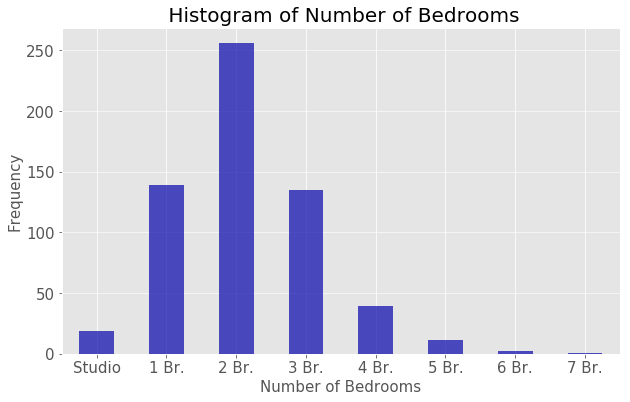

In [116]:
plt.figure(figsize=[10,6])

plt.bar(bin_edges[:-1], hist, width = 0.5, color='#0504aa',alpha=0.7,  tick_label=['Studio','1 Br.','2 Br.','3 Br.','4 Br.','5 Br.','6 Br.','7 Br.'])
plt.xlim(min(bin_edges)-0.5, max(bin_edges)-0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Bedrooms',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title(' Histogram of Number of Bedrooms',fontsize=20)


## Histogram of price of properties on sale

In [17]:
 hist,bin_edges = np.histogram(listing_data_venues['price'], bins=np.arange(100000, 2000000,100000).tolist())
print(len(bin_edges))
print(len(hist))


19
18


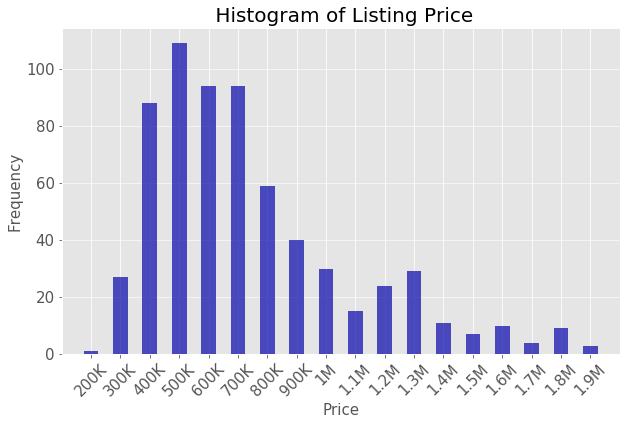

In [18]:
plt.figure(figsize=[10,6])

plt.bar(bin_edges[:-1], hist, width = 50000, color='#0504aa',alpha=0.7, tick_label=[ '200K', '300K', '400K', '500K', '600K', '700K', '800K', '900K', '1M', '1.1M', '1.2M', '1.3M', '1.4M', '1.5M', '1.6M', '1.7M', '1.8M', '1.9M'])
plt.xlim(min(bin_edges)-100000, max(bin_edges))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Price',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title(' Histogram of Listing Price',fontsize=20)

plt.show()


In [14]:
listing_data_venues.head()

,index,price,type,address,url,agent_url,postcode,number_bedrooms,search_date,District Name,...,Bakery,Bar,Indian Restaurant,Restaurant,Burger Joint,Supermarket,Bus Stop,Cocktail Bar,Plaza,Theater
0,0,510000.0,1 bedroom apartment for sale,"Osiers Square, Wandsworth, SW18",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW18,1.0,2020-05-03 14:46:50.675486,Wandsworth,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2000000.0,4 bedroom end of terrace house for sale,"Malvern Terrace, Islington, London, N1",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N1,4.0,2020-05-03 14:46:50.675486,Head district,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,2,2000000.0,3 bedroom duplex for sale,"The Avenue,\r\nLondon,\r\nNW6",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/developer/branch/Re...,NW6,3.0,2020-05-03 14:46:50.675486,Kilburn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2000000.0,3 bedroom flat for sale,"Milliner House, Hortensia Road, London, SW10",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW10,3.0,2020-05-03 14:46:50.675486,West Brompton,...,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
4,5,2000000.0,4 bedroom terraced house for sale,"Aubert Park, London, N5",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N5,4.0,2020-05-03 14:46:50.675486,Highbury,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


### Next, I plot the top 20 postcodes with the highest nb. of listings. 

In [19]:
nb_listing=pd.DataFrame(listing_data_venues.groupby('postcode').count().price).reset_index()
#nb_listing.head()
nb_listing=nb_listing.sort_values(by=['price'], ascending=False).iloc[0:20,]
nb_listing.set_index('postcode', inplace=True)
nb_listing.rename(columns={"price":"Nb. of Listings"}, inplace=True)
nb_listing.head()

,Nb. of Listings
postcode,
E14,43
N1,22
SE1,19
SW11,18
NW6,17


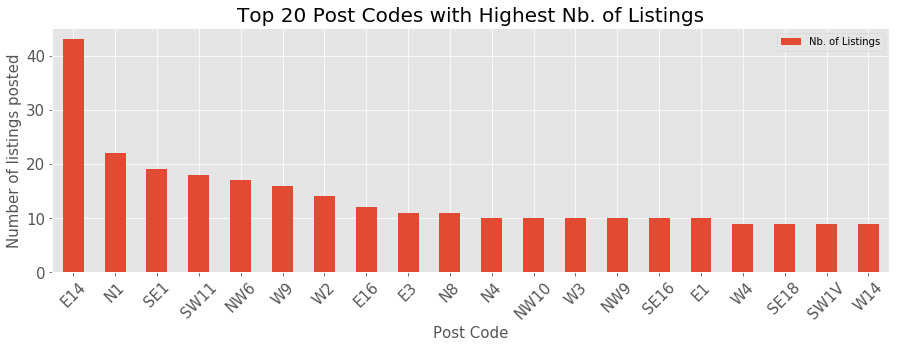

In [119]:
nb_listing.plot(kind='bar', figsize=(15, 4.5))

plt.xlabel('Post Code',fontsize=15) # add to x-label to the plot
plt.ylabel('Number of listings posted',fontsize=15) # add y-label to the plot
plt.title('Top 20 Post Codes with Highest Nb. of Listings',fontsize=20) # add title to the plot
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Now in order to understand the relative real estate price of different areas, I'll next look at the price of a studio, 1Br. and 2 Br. flat by district. 

In [21]:
studio_data=listing_data_venues[listing_data_venues.number_bedrooms==0]
studio_data.dropna(subset=['District Name'], inplace=True)
studio_data_summary=studio_data.groupby('District Name')['price'].mean()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [22]:
studio_data_summary=studio_data_summary.to_frame()
studio_data_summary.reset_index(inplace=True)
studio_data_summary.sort_values(by=['price'], ascending=False, inplace=True)

(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.,
        700000., 800000.]), <a list of 9 Text yticklabel objects>)

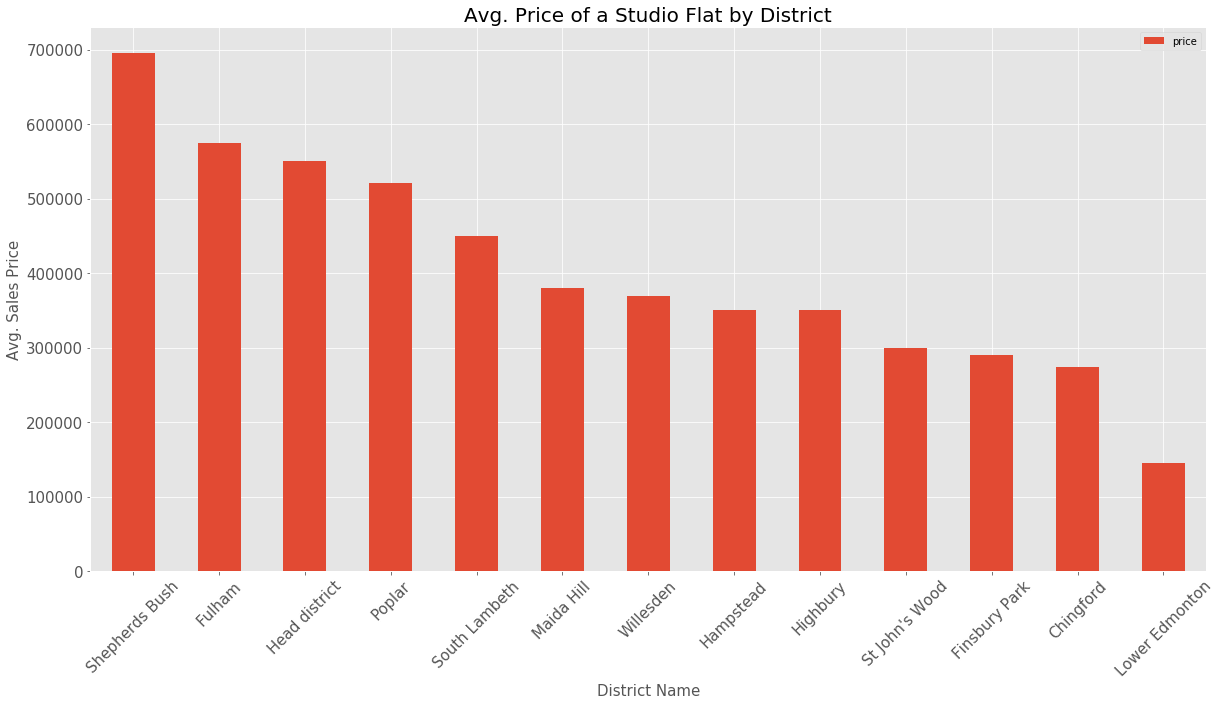

In [23]:
studio_data_summary.iloc[0:25].plot('District Name', 'price', kind='bar', figsize=(20,10))
plt.xlabel('District Name', fontsize=15)
plt.ylabel('Avg. Sales Price', fontsize=15)
plt.title('Avg. Price of a Studio Flat by District', size=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)

In [24]:
onebr_data=listing_data_venues[listing_data_venues.number_bedrooms==1]
onebr_data.dropna(subset=['District Name'], inplace=True)
onebr_data_summary=onebr_data.groupby('District Name')['price'].mean()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [25]:
onebr_data_summary=onebr_data_summary.to_frame()

In [26]:
onebr_data_summary.reset_index(inplace=True)

In [27]:
onebr_data_summary.sort_values(by=['price'], ascending=False, inplace=True)

(array([      0.,  200000.,  400000.,  600000.,  800000., 1000000.,
        1200000., 1400000., 1600000., 1800000.]),
 <a list of 10 Text yticklabel objects>)

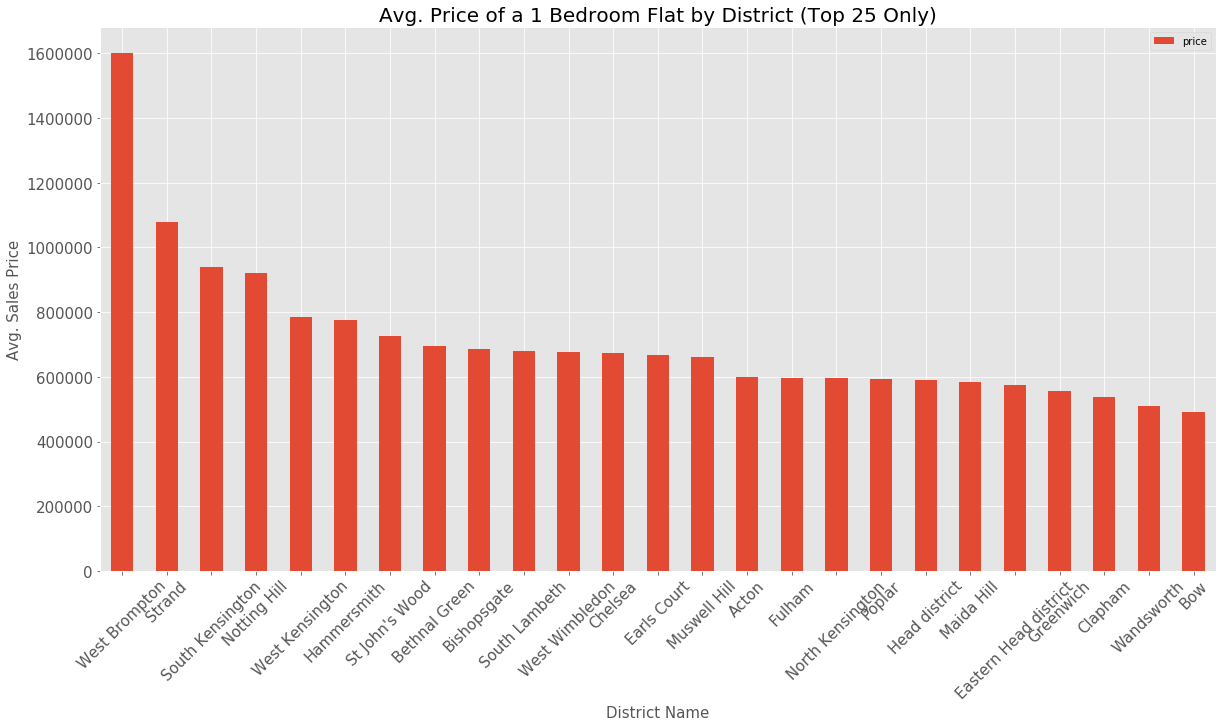

In [23]:
onebr_data_summary.iloc[0:25].plot('District Name', 'price', kind='bar', figsize=(20,10))
plt.xlabel('District Name', fontsize=15)
plt.ylabel('Avg. Sales Price', fontsize=15)
plt.title('Avg. Price of a 1 Bedroom Flat by District (Top 25 Only)', size=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)

In [28]:
twobr_data=listing_data_venues[listing_data_venues.number_bedrooms==2]
twobr_data.dropna(subset=['District Name'], inplace=True)
twobr_data_summary=twobr_data.groupby('District Name')['price'].mean()
twobr_data_summary=twobr_data_summary.to_frame()
twobr_data_summary.reset_index(inplace=True)
twobr_data_summary.sort_values(by=['price'], ascending=False, inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(array([      0.,  200000.,  400000.,  600000.,  800000., 1000000.,
        1200000., 1400000., 1600000.]), <a list of 9 Text yticklabel objects>)

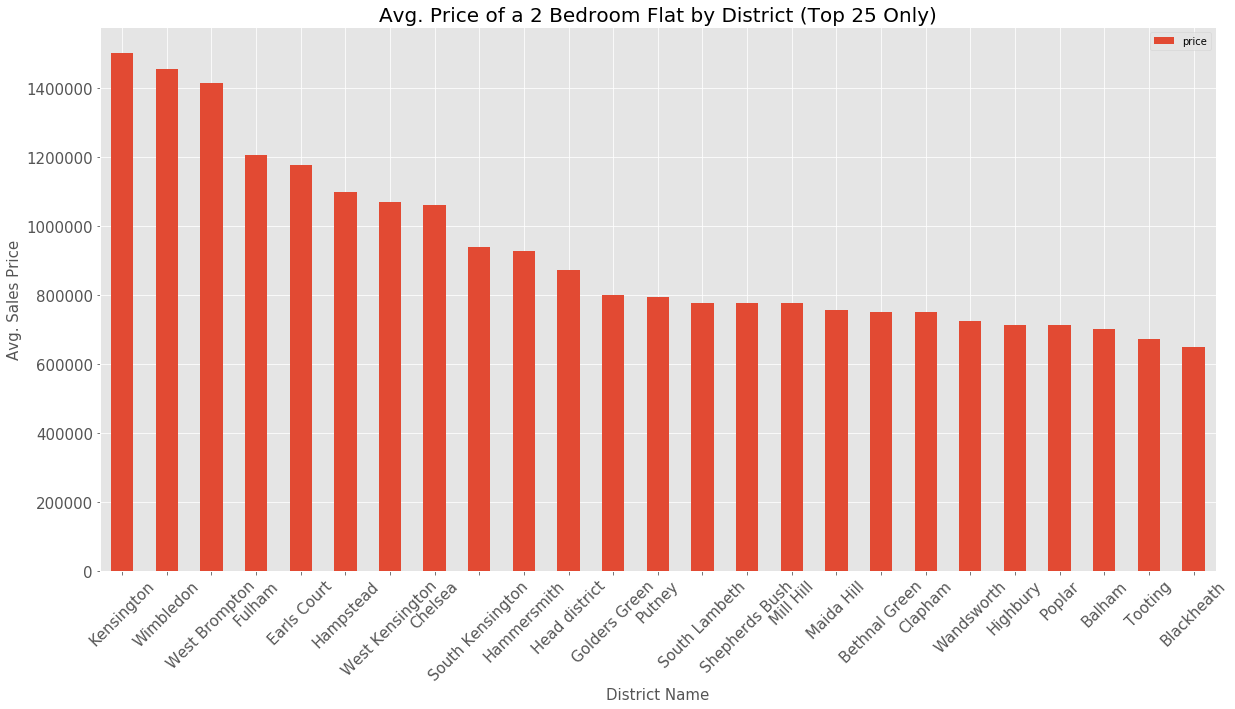

In [29]:
twobr_data_summary.iloc[0:25].plot('District Name', 'price', kind='bar', figsize=(20,10))
plt.xlabel('District Name', fontsize=15)
plt.ylabel('Avg. Sales Price', fontsize=15)
plt.title('Avg. Price of a 2 Bedroom Flat by District (Top 25 Only)', size=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)

In [30]:
threebr_data=listing_data_venues[listing_data_venues.number_bedrooms==3]
threebr_data.dropna(subset=['District Name'], inplace=True)
threebr_data_summary=threebr_data.groupby('District Name')['price'].mean()
threebr_data_summary=threebr_data_summary.to_frame()
threebr_data_summary.reset_index(inplace=True)
threebr_data_summary.sort_values(by=['price'], ascending=False, inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(array([      0.,  250000.,  500000.,  750000., 1000000., 1250000.,
        1500000., 1750000., 2000000.]), <a list of 9 Text yticklabel objects>)

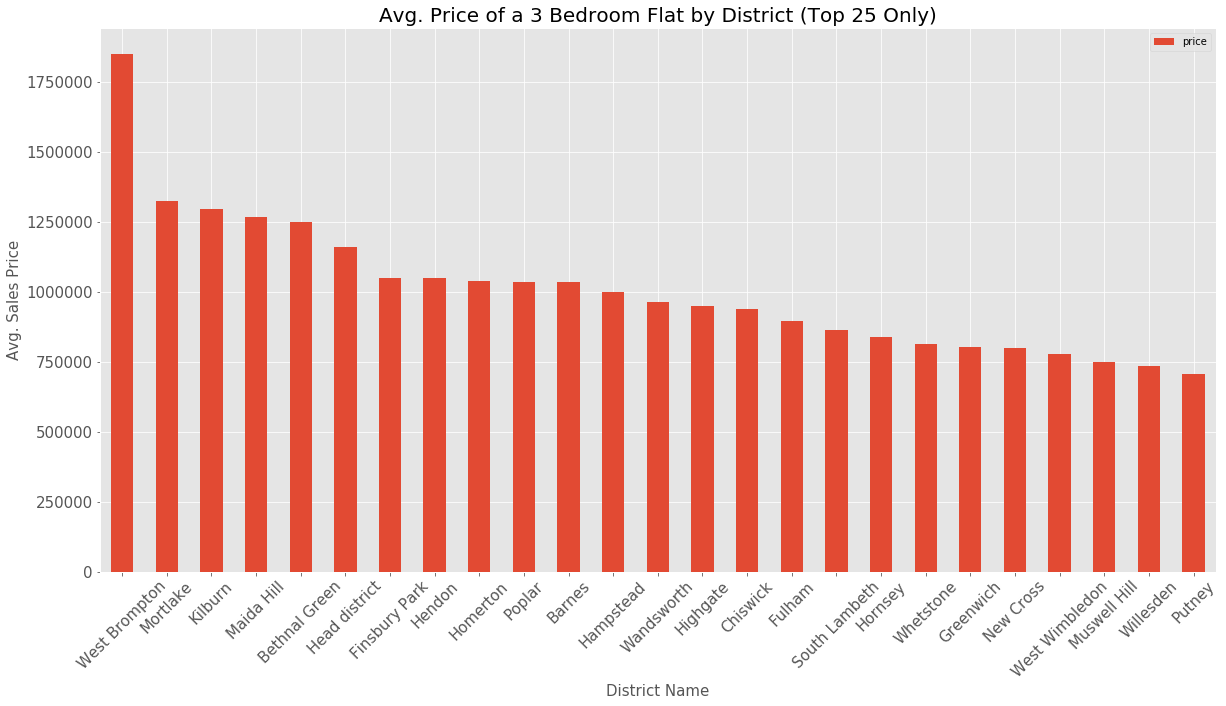

In [28]:
threebr_data_summary.iloc[0:25].plot('District Name', 'price', kind='bar', figsize=(20,10))
plt.xlabel('District Name', fontsize=15)
plt.ylabel('Avg. Sales Price', fontsize=15)
plt.title('Avg. Price of a 3 Bedroom Flat by District (Top 25 Only)', size=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)

In [32]:
fourbr_data=listing_data_venues[listing_data_venues.number_bedrooms==4]
fourbr_data.dropna(subset=['District Name'], inplace=True)
fourbr_data_summary=fourbr_data.groupby('District Name')['price'].mean()
fourbr_data_summary=fourbr_data_summary.to_frame()
fourbr_data_summary.reset_index(inplace=True)
fourbr_data_summary.sort_values(by=['price'], ascending=False, inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(array([      0.,  250000.,  500000.,  750000., 1000000., 1250000.,
        1500000., 1750000., 2000000., 2250000.]),
 <a list of 10 Text yticklabel objects>)

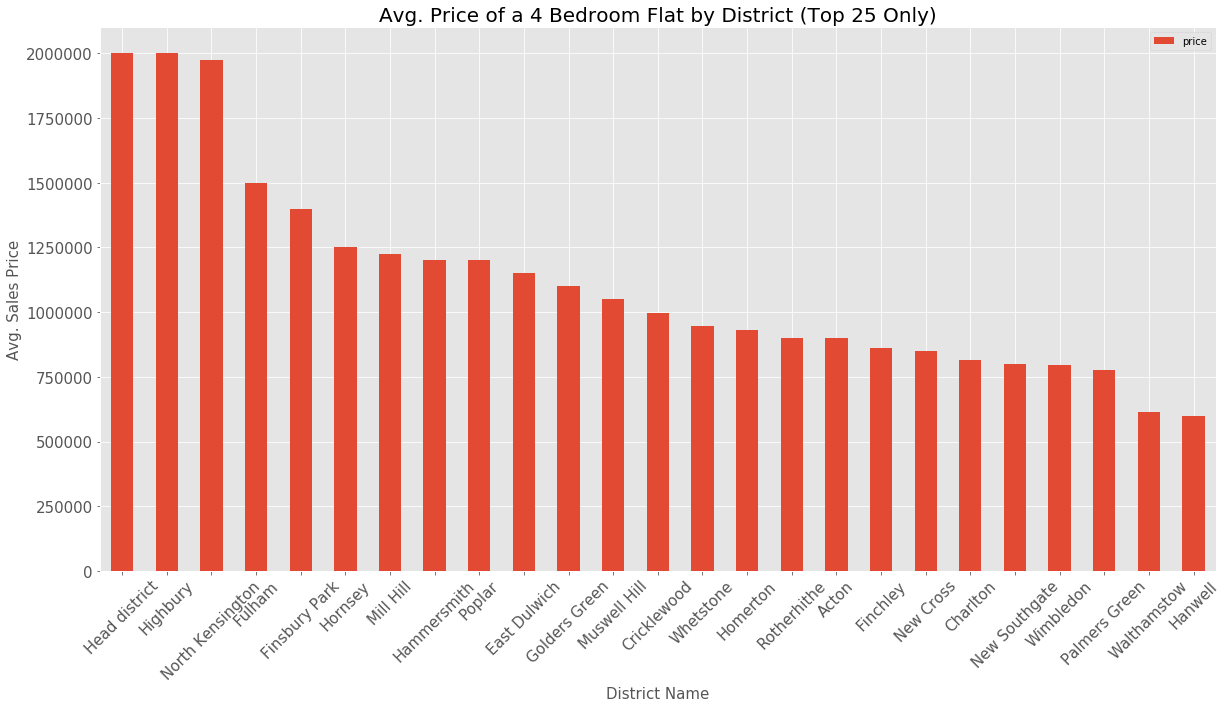

In [33]:
fourbr_data_summary.iloc[0:25].plot('District Name', 'price', kind='bar', figsize=(20,10))
plt.xlabel('District Name', fontsize=15)
plt.ylabel('Avg. Sales Price', fontsize=15)
plt.title('Avg. Price of a 4 Bedroom Flat by District (Top 25 Only)', size=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)

## The analysis above shows us that the relative cost of different districtschanges by the flat size. For smaller flats such as Studio or 1 or 2 bedrooms, most expensive neighborhoods are South Kensington, Notting Hill, West Kensington, Fulham and St. John's Wood. For larger flats that are better suited for families, most expensive districts are West Brompton, Highbury, North Kensington and Mortlake. We also note that the deduction for larger flats could be biased as the number of listings in each district is very few to make a general statement. 

# ------------------------------------------------------------------------------------------------------------------------------------------
# 5. Clustering similar listings to make recommendations to potential buyers. 

In [34]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

In [35]:
listing_data_venues.dropna(subset=['price'], inplace=True)
listing_data_venues.dropna(subset=['number_bedrooms'], inplace=True)
listing_data_venues.dropna(subset=['District Name'], inplace=True)
listing_data_venues.dropna(subset=['Pub'], inplace=True)
#listing_data_venues_500=listing_data_venues[listing_data_venues.price<=500000]

In [36]:
listing_data_venues.price.describe()

count    6.020000e+02
mean     6.924012e+05
std      3.582202e+05
min      1.450000e+05
25%      4.385000e+05
50%      6.000000e+05
75%      8.450000e+05
max      2.000000e+06
Name: price, dtype: float64

In [37]:
from sklearn.preprocessing import StandardScaler
X = listing_data_venues[['price','number_bedrooms', 'Pub', 'Coffee Shop', 'Café', 'Hotel', 'Grocery Store',
       'Italian Restaurant', 'Pizza Place', 'Park', 'Gym / Fitness Center',
      'Sandwich Place', 'Bakery', 'Bar', 'Indian Restaurant', 'Restaurant',
       'Burger Joint', 'Supermarket', 'Bus Stop', 'Cocktail Bar', 'Plaza',
       'Theater' ]] .values

X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-0.50961077, -1.09275773,  2.45763328, ..., -0.32253359,
        -0.34653596, -0.23351599],
       [ 3.65330092,  1.7925061 ,  0.1438561 , ...,  0.48987319,
        -0.34653596,  0.88217152],
       [ 3.65330092,  0.83075149,  0.1438561 , ..., -0.32253359,
        -0.34653596, -0.23351599],
       ...,
       [-1.23602489, -0.13100312, -0.18668349, ..., -0.32253359,
        -0.34653596, -0.23351599],
       [-1.23602489, -1.09275773, -0.51722309, ..., -0.32253359,
        -0.34653596, -0.23351599],
       [-1.23616458, -0.13100312, -0.84776269, ..., -0.32253359,
        -0.34653596, -0.23351599]])

### Choosing model parameter k

[10635.377159326468, 9704.410622660705, 8629.586518516307, 8133.364856094965, 7557.399157389997, 7248.250130141758, 6903.41925822263, 6444.562826599453, 6134.056152248506, 5923.0712357508855, 5718.543593292592, 5578.6193057316905, 5308.432131305073, 5157.852506492726, 5071.695194895822, 4907.538734208609, 4771.243254248324, 4668.08036404795]


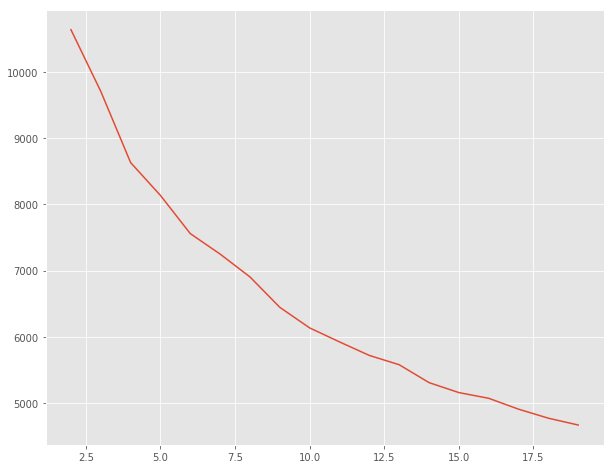

In [122]:
scores=[]

for clusterNum in range(2,20,1):
    k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
    k_means.fit(Clus_dataSet)
    labels = k_means.labels_
    scores.append(-1*k_means.score(Clus_dataSet))
    

print(scores)

plt.figure(figsize=(10,8))
plt.plot(range(2,20,1),scores)


### Elbow method tells us to use k=4. So in the analysis below I will focus on 4 clusters.

### Modeling

In [107]:
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(Clus_dataSet)
labels = k_means.labels_
print(labels)

[1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 2 0 0 0 1 0 0 0 2 0 0 1 1 1
 0 1 0 0 1 0 1 1 0 3 1 0 0 1 0 0 1 0 0 1 1 1 1 0 3 1 0 1 1 1 1 0 0 1 1 0 3
 1 0 1 0 0 1 0 0 0 0 0 3 0 1 1 3 1 1 0 0 0 1 1 1 2 3 2 1 0 1 1 1 1 1 1 0 1
 1 0 1 2 1 2 0 1 0 1 1 1 1 1 1 0 3 0 1 3 1 1 1 1 0 1 1 1 1 0 0 3 0 0 1 1 1
 1 1 1 1 0 1 1 1 1 3 0 0 0 0 0 1 0 0 2 2 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 2 0 1 1 1
 1 0 1 3 1 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 2 1 0 3 1 0 0 0 2 1 0 0
 0 1 1 2 1 1 0 0 1 0 1 0 1 0 2 1 0 1 1 1 1 0 1 0 1 2 2 1 1 0 1 1 1 1 1 1 0
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 2 1 1 1 0 0 1 1 1 1 1 0 1 2 1 0 0 1 0 1 0 0
 0 0 1 1 0 1 1 2 0 0 1 2 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 2 1 1 1 0 2 1 0
 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 2 1 1 0 1 2 1 1 1 0 0 0 1 0 2
 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 

### Insights

In [108]:
listing_data_post=listing_data_venues
listing_data_post["Clus_km"] = labels
listing_data_post.head(5)

,index,price,type,address,url,agent_url,postcode,number_bedrooms,search_date,District Name,...,Bar,Indian Restaurant,Restaurant,Burger Joint,Supermarket,Bus Stop,Cocktail Bar,Plaza,Theater,Clus_km
0,0,510000.0,1 bedroom apartment for sale,"Osiers Square, Wandsworth, SW18",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW18,1.0,2020-05-03 14:46:50.675486,Wandsworth,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,2000000.0,4 bedroom end of terrace house for sale,"Malvern Terrace, Islington, London, N1",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N1,4.0,2020-05-03 14:46:50.675486,Head district,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1
2,2,2000000.0,3 bedroom duplex for sale,"The Avenue,\r\nLondon,\r\nNW6",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/developer/branch/Re...,NW6,3.0,2020-05-03 14:46:50.675486,Kilburn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,4,2000000.0,3 bedroom flat for sale,"Milliner House, Hortensia Road, London, SW10",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,SW10,3.0,2020-05-03 14:46:50.675486,West Brompton,...,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0
4,5,2000000.0,4 bedroom terraced house for sale,"Aubert Park, London, N5",http://www.rightmove.co.uk/property-for-sale/p...,http://www.rightmove.co.uk/estate-agents/agent...,N5,4.0,2020-05-03 14:46:50.675486,Highbury,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1


In [40]:
listing_data_post.groupby('Clus_km').mean()

,index,price,number_bedrooms,Latitude,Longitude,Pub,Coffee Shop,Café,Hotel,Grocery Store,...,Bakery,Bar,Indian Restaurant,Restaurant,Burger Joint,Supermarket,Bus Stop,Cocktail Bar,Plaza,Theater
Clus_km,,,,,,,,,,,,,,,,,,,,,
0,226.550000,988875.000000,2.000000,51.519312,-0.103485,10.700000,11.450000,8.650000,3.200000,3.000000,...,3.650000,7.050000,0.950000,4.850000,1.850000,0.000000,0.000000,5.100000,0.750000,2.900000
1,566.836512,622618.043597,2.283379,51.545150,-0.144069,1.332425,0.765668,1.068120,0.446866,0.724796,...,0.239782,0.272480,0.340599,0.209809,0.062670,0.226158,0.558583,0.073569,0.029973,0.057221
2,447.333333,716515.000000,1.444444,51.504478,-0.016651,0.740741,7.629630,3.481481,1.851852,1.185185,...,1.518519,1.888889,1.925926,2.222222,4.185185,0.777778,0.444444,0.000000,3.481481,0.000000
3,427.069149,793623.877660,1.962766,51.512027,-0.129518,4.367021,3.781915,3.159574,2.872340,2.212766,...,1.340426,0.813830,1.127660,0.984043,0.750000,0.984043,0.606383,0.585106,0.319149,0.250000


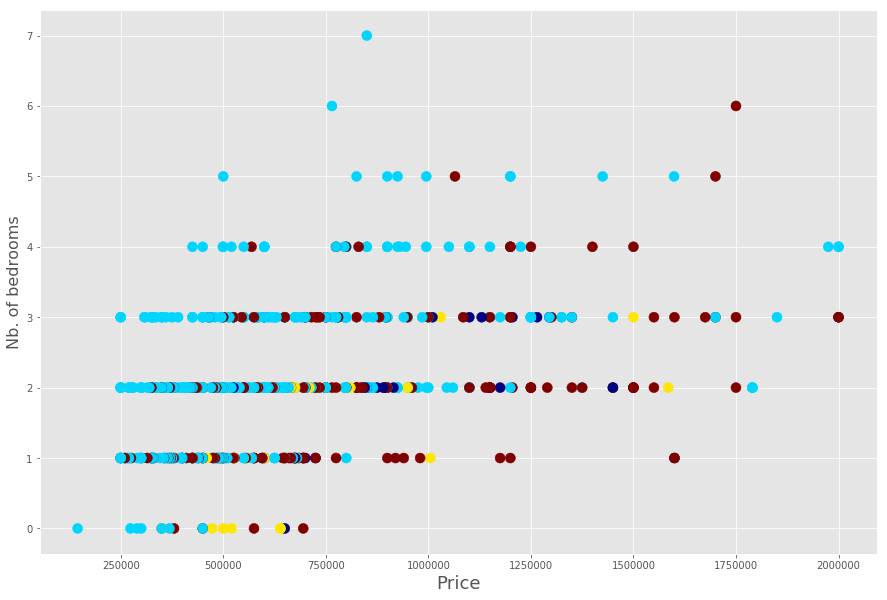

In [59]:
plt.figure(figsize=(15,10))
plt.scatter(listing_data_post['price'], listing_data_post['number_bedrooms'], s=100, c=listing_data_post['Clus_km'], cmap='jet')
plt.xlabel('Price', fontsize=18)
plt.ylabel('Nb. of bedrooms', fontsize=16)

plt.show()

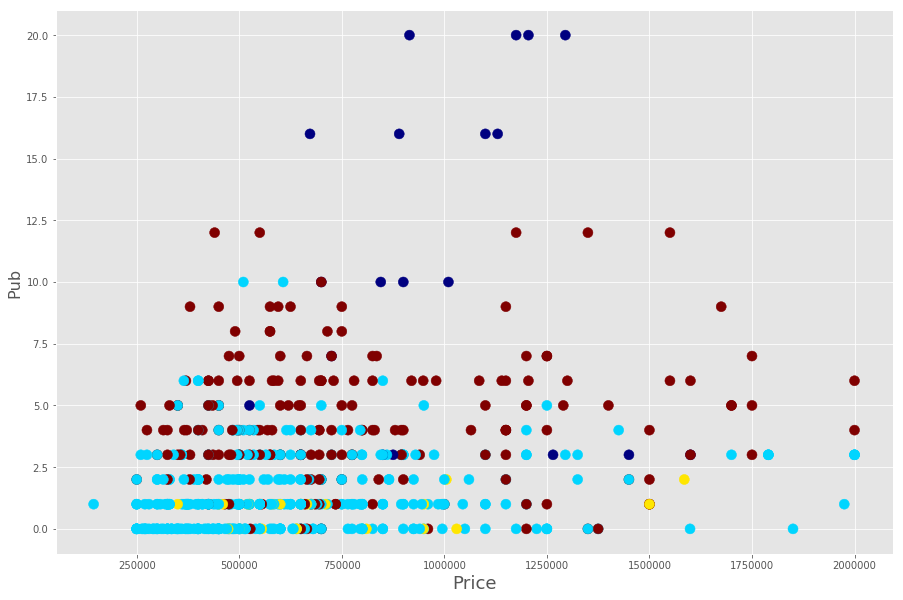

In [61]:
plt.figure(figsize=(15,10))
plt.scatter(listing_data_post['price'], listing_data_post['Pub'], s=100, c=listing_data_post['Clus_km'], cmap='jet')
plt.xlabel('Price', fontsize=18)
plt.ylabel('Pub', fontsize=16)

plt.show()

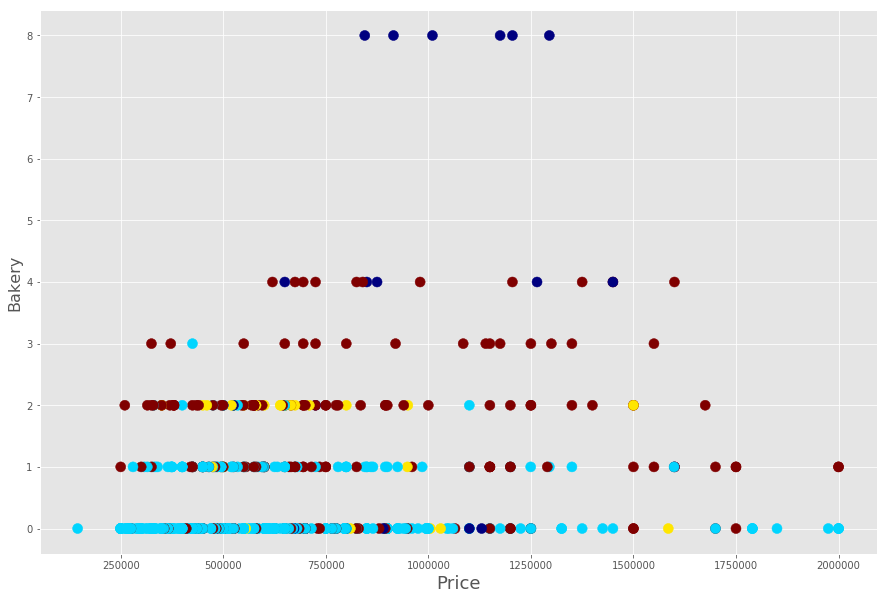

In [66]:
plt.figure(figsize=(15,10))
plt.scatter(listing_data_post['price'], listing_data_post['Bakery'], s=100, c=listing_data_post['Clus_km'], cmap='jet')
plt.xlabel('Price', fontsize=18)
plt.ylabel('Bakery', fontsize=16)

plt.show()

In [67]:
import seaborn as sns

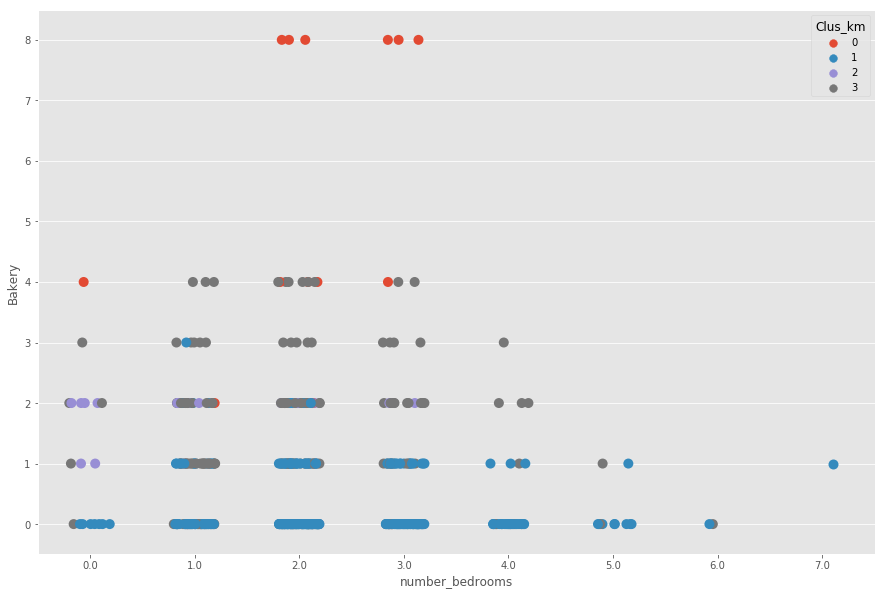

In [78]:
plt.figure(figsize=(15,10))
sns.stripplot('number_bedrooms', 'Bakery', data= listing_data_post, jitter=0.2, hue='Clus_km', size=10)

### Check Cluster 0 by district distribution

In [90]:
listing_data_post[listing_data_post.Clus_km==2].groupby('postcode').count()

,index,price,type,address,url,agent_url,number_bedrooms,search_date,District Name,Latitude,...,Bar,Indian Restaurant,Restaurant,Burger Joint,Supermarket,Bus Stop,Cocktail Bar,Plaza,Theater,Clus_km
postcode,,,,,,,,,,,,,,,,,,,,,
E14,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
SE10,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


## below we show that clustering is not purely based on postcode or district. cross-postcode recommendation is also possible. 

In [123]:
listing_data_post.groupby('postcode')['Clus_km'].unique()

postcode
E1         [0, 1]
E10           [1]
E11           [1]
E12           [1]
E13        [1, 0]
E14     [1, 2, 0]
E15           [1]
E16           [1]
E17        [0, 1]
E18           [1]
E2      [3, 1, 0]
E20        [0, 1]
E3            [1]
E4            [1]
E6            [1]
E7            [1]
E8            [1]
E9            [1]
EC2           [0]
N1      [1, 0, 3]
N10        [1, 0]
N11           [1]
N12           [1]
N13           [1]
N14           [1]
N15           [1]
N16        [1, 0]
N17           [1]
N19           [0]
N2         [1, 0]
          ...    
SW12          [1]
SW13          [1]
SW14          [1]
SW15       [1, 0]
SW16          [1]
SW17       [0, 1]
SW18       [1, 0]
SW19          [1]
SW20          [1]
SW3           [0]
SW4           [0]
SW5           [0]
SW6        [0, 1]
SW7           [0]
SW8           [1]
SW9           [1]
W10           [1]
W11        [0, 1]
W12        [0, 1]
W13        [0, 1]
W14        [0, 1]
W2         [0, 1]
W3            [1]
W4         [1, 0]
W